<a href="https://colab.research.google.com/github/aviralmansingka/dotfiles/blob/develop/PMPP_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting started with CUDA

### Setup

In [ ]:
!pip install torch torchvision matplotlib wurlitzer ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 8.8 MB/s eta 0:00:00


In [ ]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [ ]:
img = io.read_image("puppy.jpg")
print(img.shape)
img[:2, :3, :4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [ ]:
def show_img(x, figsize=(8,6), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis('off')
  if len(x.shape) == 3:
    x = x.permute(1, 2, 0)
  plt.imshow(x.cpu(), **kwargs)

In [ ]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,w*h

(3, 150, 216, 32400)

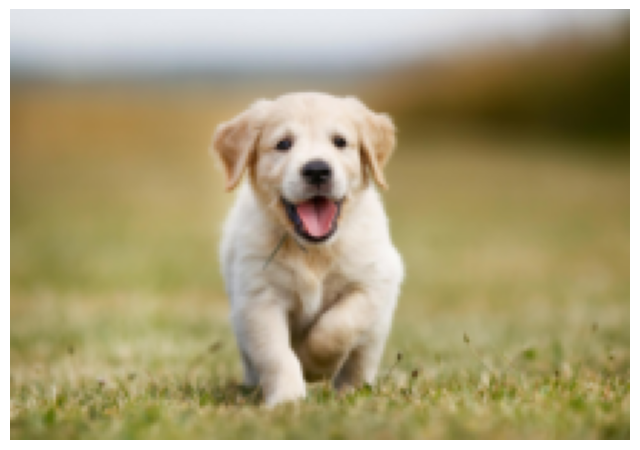

In [ ]:
show_img(img2)

## RGB -> Grey

In [ ]:
def rgb2grey_py(x):
  c,h,w = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  for i in range(n):
    res[i] = 0.2989 * x[i] + 0.5870*x[i + n] + 0.1140*x[i + 2*n]
  return res.view(h,w)

In [ ]:
%%time
img2_g = rgb2grey_py(img2)

CPU times: user 1.93 s, sys: 9.46 ms, total: 1.94 s
Wall time: 2.33 s


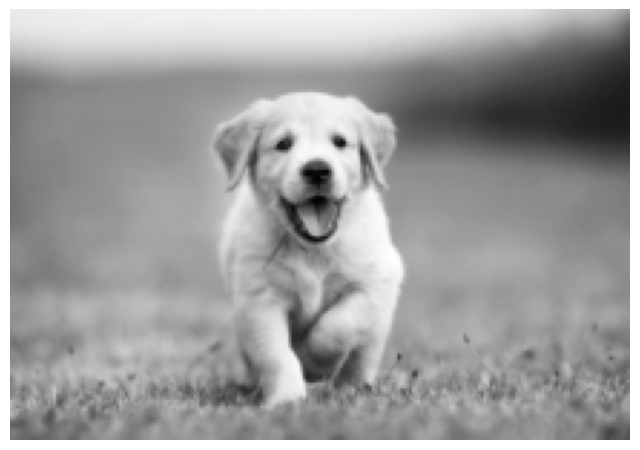

In [ ]:
show_img(img2_g, cmap='gray')

In [ ]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
  i = blockidx*blockdim + threadidx
  if i < n:
    out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2*n]

In [ ]:
def rgb2grey_pybk(x):
  c, h, w = x.shape
  print(c,h,w)
  n = h * w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  threads = 256
  blocks = int(math.ceil(h*w/threads))
  blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
  return res.view(h,w)

3 150 216


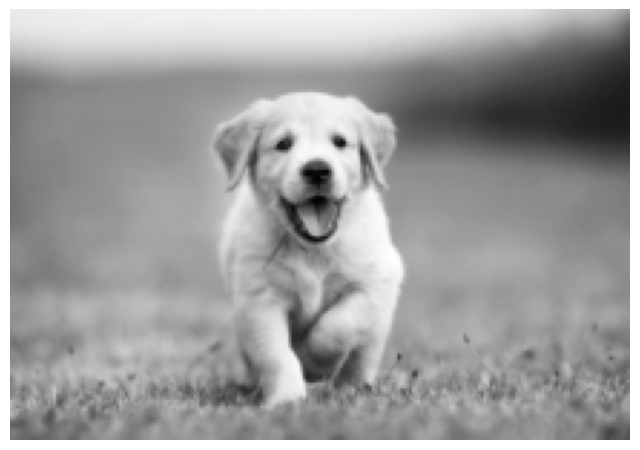

In [ ]:
img2_g = rgb2grey_pybk(img2)
show_img(img2_g, cmap='gray')

## CUDA Setup

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [ ]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                     extra_cuda_cflags=['-O2'] if opt else [], verbose=verbose, name='inline_ext')

In [ ]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a cuda tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [ ]:
# Kernel computes single element
cuda_src = cuda_begin + r'''
__global__ void vector_add_kernel(float* a, float* b, float* out, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < n) {
    out[i] = a[i] + b[i];
  }
}

torch::Tensor vector_add(torch::Tensor a, torch::Tensor b) {
  CHECK_INPUT(a);
  CHECK_INPUT(b);
  int h = a.size(0);
  int w = a.size(1);
  printf("h*w: %d x %d", h, w);
  auto output = torch::empty({h, w}, a.options());
  int threads = 256;
  vector_add_kernel<<<cdiv(w*h, threads), threads>>>(
    a.data_ptr<float>(),
    b.data_ptr<float>(),
    output.data_ptr<float>(),
    w*h);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return output;
}
'''

In [ ]:
# Kernel computes single row
cuda_src = cuda_begin + r'''
__global__ void vector_add_kernel(float* a, float* b, float* out, int w, int n) {
  int i = (blockIdx.x * blockDim.x + threadIdx.x) * w;

  for (int j = 0; j < w; j++) {
    int k = i + j;
    if (k < n) {
      out[k] = a[k] + b[k];
    }
  }
}

torch::Tensor vector_add(torch::Tensor a, torch::Tensor b) {
  CHECK_INPUT(a);
  CHECK_INPUT(b);
  int h = a.size(0);
  int w = a.size(1);
  printf("h*w: %d x %d", h, w);
  auto output = torch::empty({h, w}, a.options());
  int threads = 32;
  vector_add_kernel<<<cdiv(h, threads), threads>>>(
    a.data_ptr<float>(),
    b.data_ptr<float>(),
    output.data_ptr<float>(),
    w,
    w*h);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return output;
}
'''

In [ ]:
# Kernel computes single col
cuda_src = cuda_begin + r'''
__global__ void vector_add_kernel(float* a, float* b, float* out, int w, int n) {
  int i = (blockIdx.x * blockDim.x + threadIdx.x) * w;

  for (int j = 0; j < w; j++) {
    int k = i + j;
    if (k < n) {
      out[k] = a[k] + b[k];
    }
  }
}

torch::Tensor vector_add(torch::Tensor a, torch::Tensor b) {
  CHECK_INPUT(a);
  CHECK_INPUT(b);
  int h = a.size(0);
  int w = a.size(1);
  printf("h*w: %d x %d", h, w);
  auto output = torch::empty({h, w}, a.options());
  int threads = 32;
  vector_add_kernel<<<cdiv(h, threads), threads>>>(
    a.data_ptr<float>(),
    b.data_ptr<float>(),
    output.data_ptr<float>(),
    w,
    w*h);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return output;
}
'''

In [ ]:
cpp_src = "torch::Tensor vector_add(torch::Tensor a, torch::Tensor b);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['vector_add'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 12 and re-building as inline_ext_v12...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v12...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v12 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v12 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch

Loading extension module inline_ext_v12...


In [ ]:
a = torch.rand(1024, 1024, dtype=torch.float32)
b = torch.rand(1024, 1024, dtype=torch.float32)
a_c = a.cuda()
b_c = b.cuda()

In [ ]:
%%time

res = module.vector_add(a_c, b_c).cpu()
h,w = res.shape

h*w: 1024 x 1024CPU times: user 4.55 ms, sys: 0 ns, total: 4.55 ms
Wall time: 3.27 ms


In [ ]:
torch.allclose(res, a + b)

True